In [8]:
import pandas as pd
from scipy.stats import geom
import matplotlib.pyplot as plt
import numpy as np

In [9]:
#plt.rcParams['figure.autolayout'] = False
#plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = "\usepackage{subdepth}, \usepackage{type1cm}"

In [10]:
p=0.2

In [11]:
def plot_geom(p):
    rv = geom(p)
    x = np.arange(rv.ppf(0.01), rv.ppf(0.99))
    y = rv.pmf(x)
    mean = 1.0/p
    fig, ax = plt.subplots(1, 1, figsize=(10,10))
    ax.plot(x, y, 'ob')
    ax.vlines(x, 0, y, 'b')
    ax.set_xticks(x[::2])
    ax.set_xlabel("Years")
    ax.vlines(mean, 0, rv.pmf(mean), 'r', lw=4)
    ax.annotate('Average lifetime = {0} years'.format(mean), (mean, rv.pmf(mean)), (5, 5), textcoords='offset pixels', fontsize='x-large')

/home/prash/.pyenv/versions/posts/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


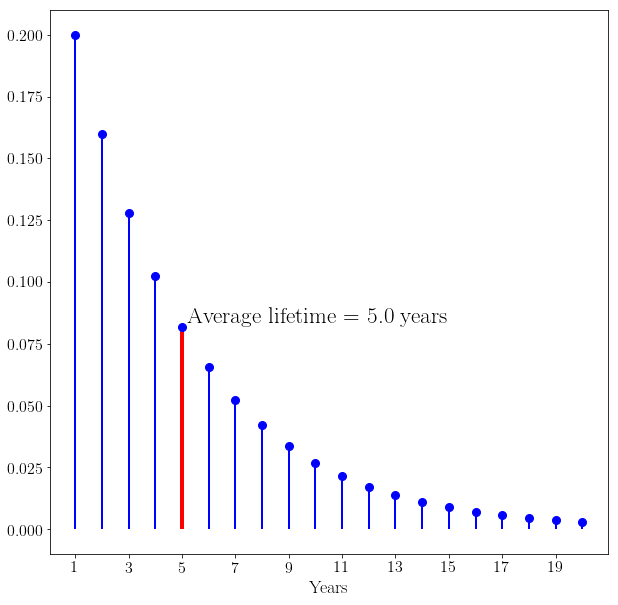

In [12]:
plot_geom(0.2)

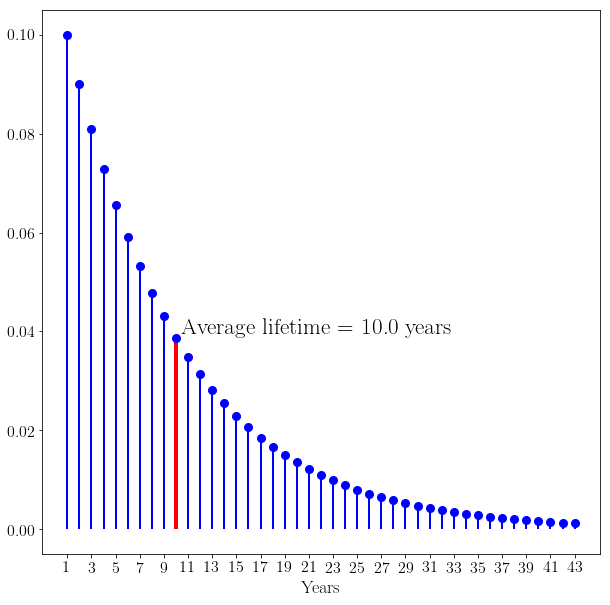

In [13]:
plot_geom(0.1)

\begin{align}
P(Y = 1) &= 0.2 \\
P(Y = 2) &= 0.8 \times 0.2 = 0.16 \\
P(Y = 3) &= 0.8 \times 0.8 \times 0.2 = 0.128
\end{align}

In general we can write this as:

\begin{align}
P(Y=y) &= p\ (1-p)^{ y-1} \\
\text{for}\ y &= 1, 2, 3 \dots
\end{align}

This is the probability mass function for the **geometric distribution**, sometimes called the **shifted geometric distribution**. It is a discrete probability distribution, which defines the probability of...

For example for $p=0.2$

\begin{equation*}
P(Y=y) = 0.2\cdot (1-0.2)^{ y-1} \\
\end{equation*}

We can plot this out:

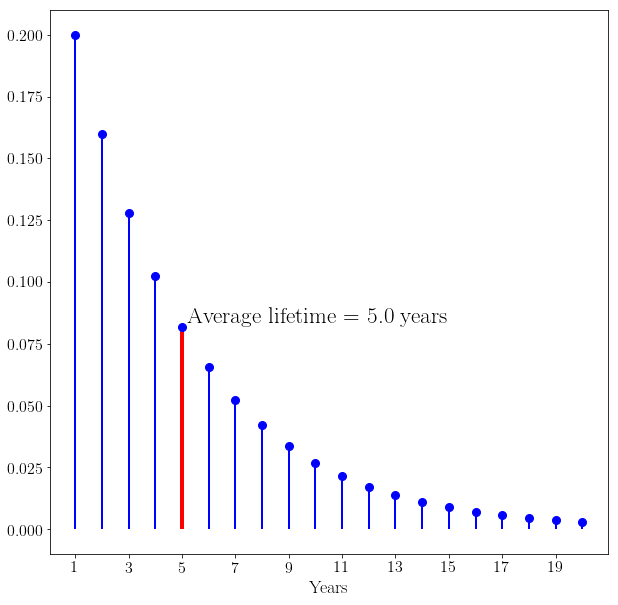

In [14]:
plot_geom(0.2)

In order to calculate the Average Customer Lifetime, we need to calculate the mean or *Expectation* of the probability distribution. The Expectation is:

\begin{align}
E[Y] &= \sum_{y=1}^{\infty} P(Y)\ y \\
E[Y] &= \sum_{y=1}^{\infty} p\ (1-p)^{ y-1}y \\
E[Y] &= p \sum_{y=1}^{\infty} (1-p)^{ y-1}y 
\end{align}

Lets substitute $q = 1-p$ for convenience:

\begin{align}
E[Y] &= p \sum_{y=1}^{\infty} q^{ y-1}y 
\end{align}

The trick here is to recognise that the summation can be replaced by a derivative of another summation, using THIS fact.

\begin{equation*}
E[Y] = p \frac{d}{dq} \Big( \sum_{y=0}^{\infty} q^{ y} \Big) 
\end{equation*}

Now, we can recognise we have a geometric series. As we know that $q < 1$, the geometric series $\sum_{y=0}^{\infty} q^{y}$ will converge to $\frac{1}{1-q}$ or $(1-q)^{-1}$
We can subsitute this for the summation:

\begin{equation*}
E[Y] = p \frac{d}{dq} \big( (1-q)^{-1} \big) \\
\end{equation*}

If we evaluate the derivative and simplify:

\begin{align}
E[Y] &= p \big( \text{-1} \cdot \text{-1}\cdot(1-q)^{-2} \big) \\
E[Y] &= \frac{p}{(1-q)^{2}} \\
E[Y] &= \frac{p}{(1-(1-p))^{2}} \\
E[Y] &= \frac{p}{p^{2}} \\
E[Y] &= \frac{1}{p}
\end{align}

Hence, we know for the geometric distribution, the mean is $\frac{1}{p}$